<u><b>Deep Learning : Principles and Practices - CSE1016 - L33 + L34</b></u>

<u><b>Name: </b></u> Nikhil V

<u><b>Registration No: </b></u> CH.EN.U4AIE22038

<u><b>Lab - 7 : </b></u> Transfer Learning and Fine Tuning on Plant Village Dataset

In [12]:
!pip install split-folders

In [13]:
!pip install tensorflow

# Importing the required modules

In [14]:
# Modules used for data handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as r
sns.set_style("whitegrid")

# Modules used for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Modules used for dataset split
import splitfolders
import os

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model

In [15]:
# Centering all the output images in the notebook.
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Dataset Exploration

In [16]:
class Dataset:

    def __init__(self, dataset_path : str):
        self.PARENT = dataset_path
        self.class_distribution = dict()
    
    def __compute_class_distributions(self):
        for dirname in os.listdir(self.PARENT):
            self.class_distribution[dirname] = len(os.listdir(os.path.join(self.PARENT, dirname)))

    def class_distributions(self):
        self.__compute_class_distributions()

        plt.figure(figsize=(10,10))
        plt.bar(self.class_distribution.keys(),
        self.class_distribution.values(),
        color=["crimson","red","orange","yellow"])
        plt.xticks(rotation=90)
        plt.title("Class Distribution of PlantVillage dataset")
        plt.xlabel("Class Label")
        plt.ylabel("Frequency of class")
        plt.show()

    def show_class_samples(self):
        rows = 5
        columns = 3
        c = 0
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for dirname in os.listdir(self.PARENT):
            img_path = r.choice(os.listdir(os.path.join(self.PARENT, dirname)))
            image = mpimg.imread(os.path.join(self.PARENT, dirname, img_path))
            axs[c//columns, c%columns].imshow(image)
            axs[c//columns, c%columns].set_title(dirname)
            c += 1
        fig.suptitle("Image Samples of Plant Village dataset")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()

## Loading the dataset

In [17]:
plant_village = Dataset("/kaggle/input/plantdisease/PlantVillage")

## Class Distribution

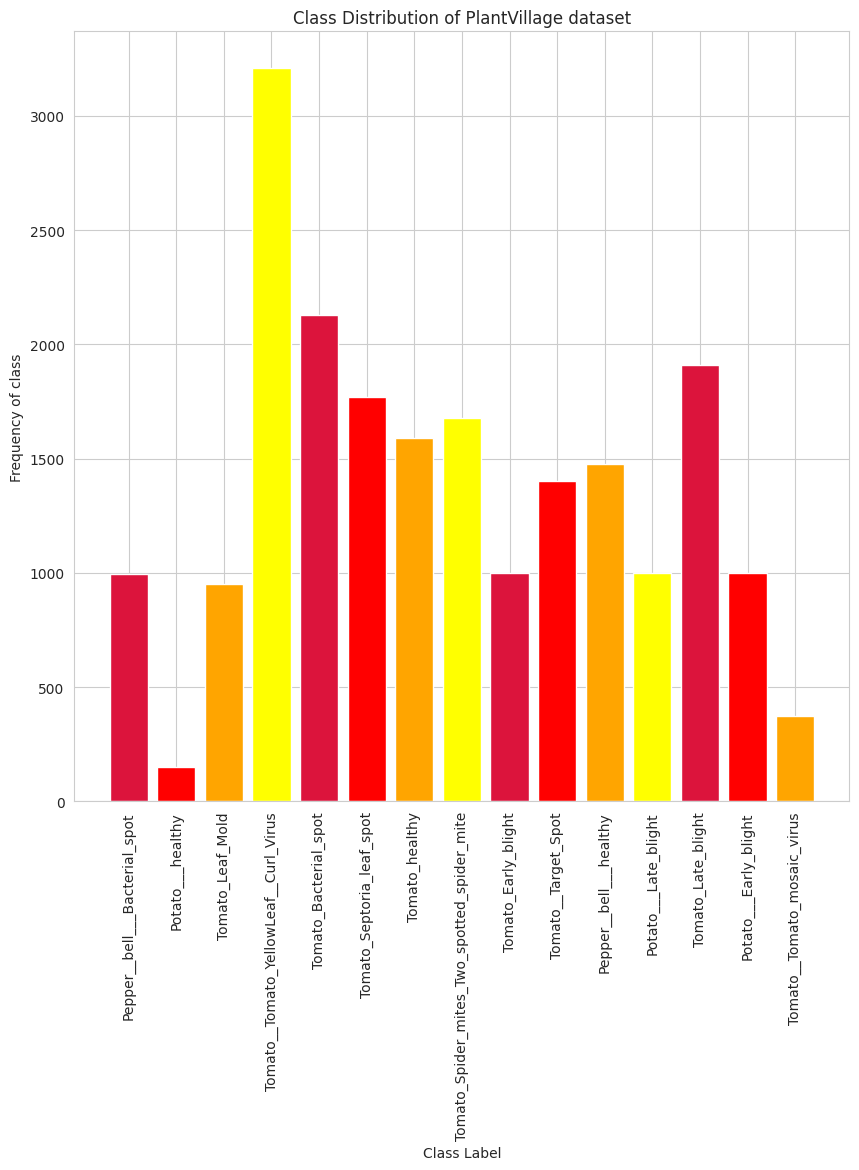

In [18]:
plant_village.class_distributions()

## Sample Images

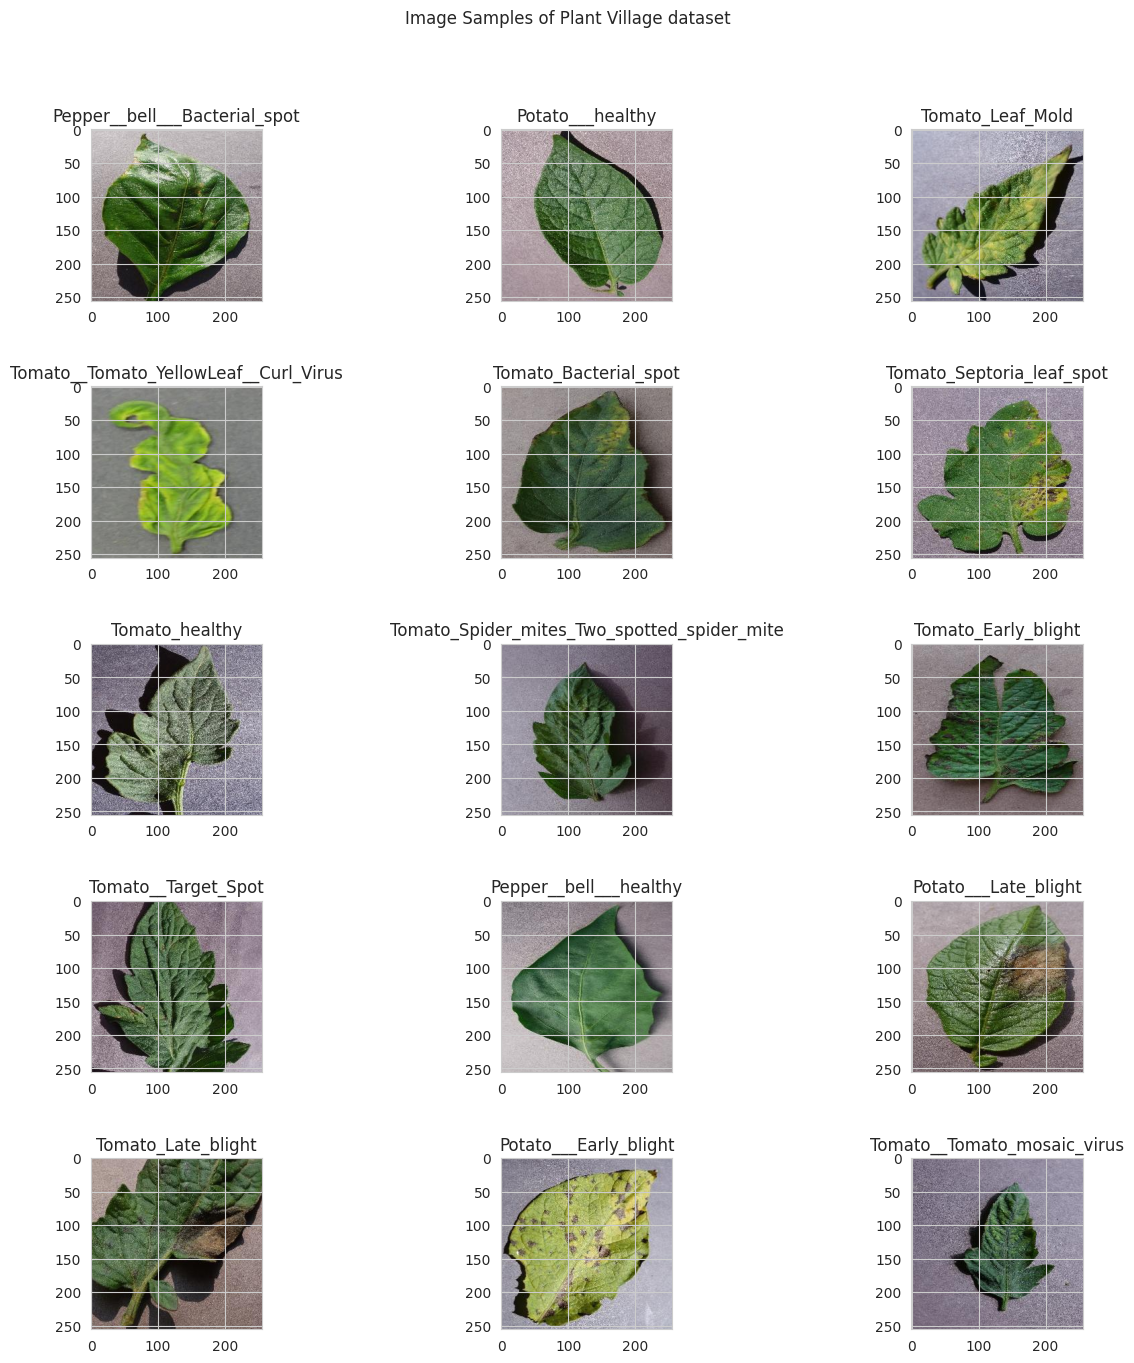

In [19]:
plant_village.show_class_samples()

# Train, Test, Validation Split

In [20]:
class DataSplit:

    def __init__(self, dataset_path : str, destination_path : str, train : float, test : float, val : float) -> None:
        self.PARENT = dataset_path
        self.TRAIN = train
        self.TEST = test
        self.VAL = val
        self.destination_path = destination_path
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.TRAIN_DIR = "dataset/train"
        self.TEST_DIR = "dataset/test"
        self.VAL_DIR = "dataset/val"

    def test_train_validation_split(self):
        assert (self.TRAIN + self.TEST + self.VAL) == 1

        splitfolders.ratio(input = self.PARENT, 
                           output = self.destination_path,
                           seed = 1337, ratio = (.8, .1, .1), 
                           group_prefix = None, 
                           move = False)

    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training'
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

In [23]:
ds = DataSplit("/kaggle/input/plantdisease/PlantVillage","dataset",0.8,0.1, 0.1)

In [24]:
ds.test_train_validation_split()

Copying files: 20639 files [03:39, 94.17 files/s] 


## Train Data Insights

In [25]:
train = Dataset("dataset/train/")

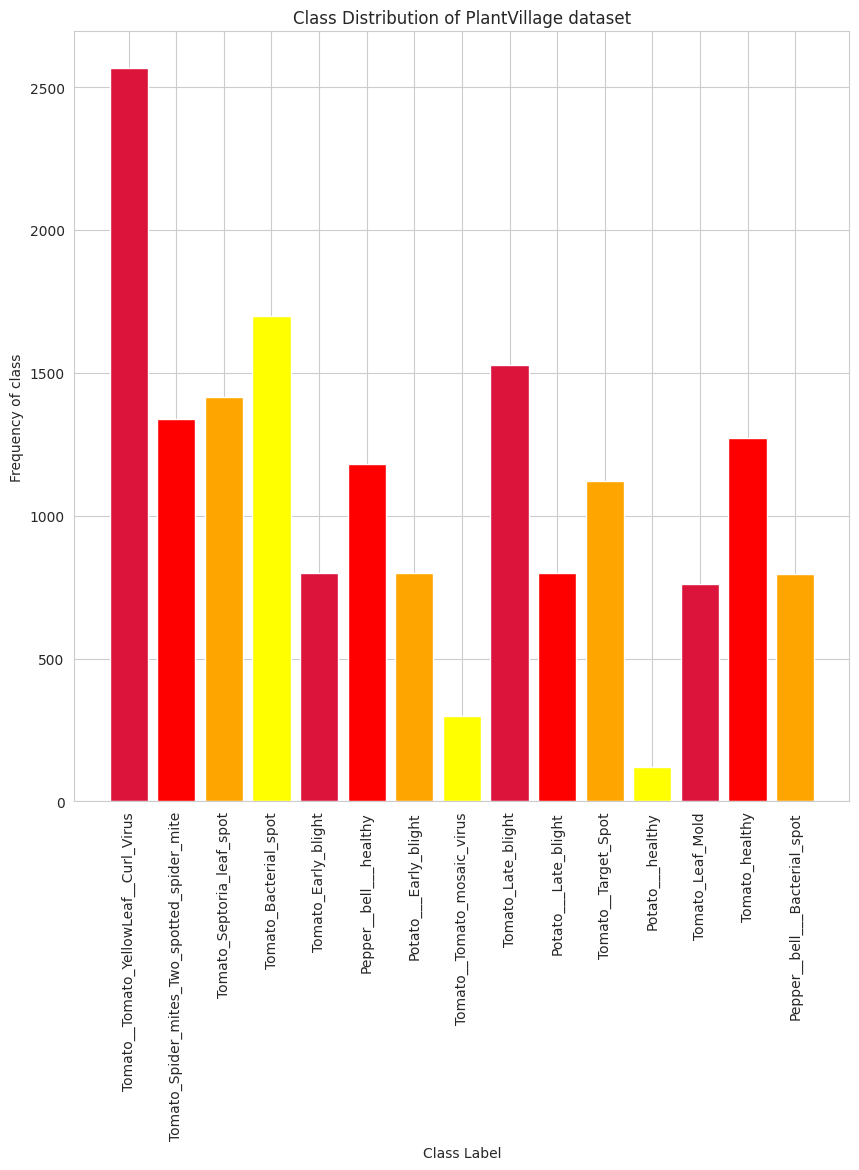

In [26]:
train.class_distributions()

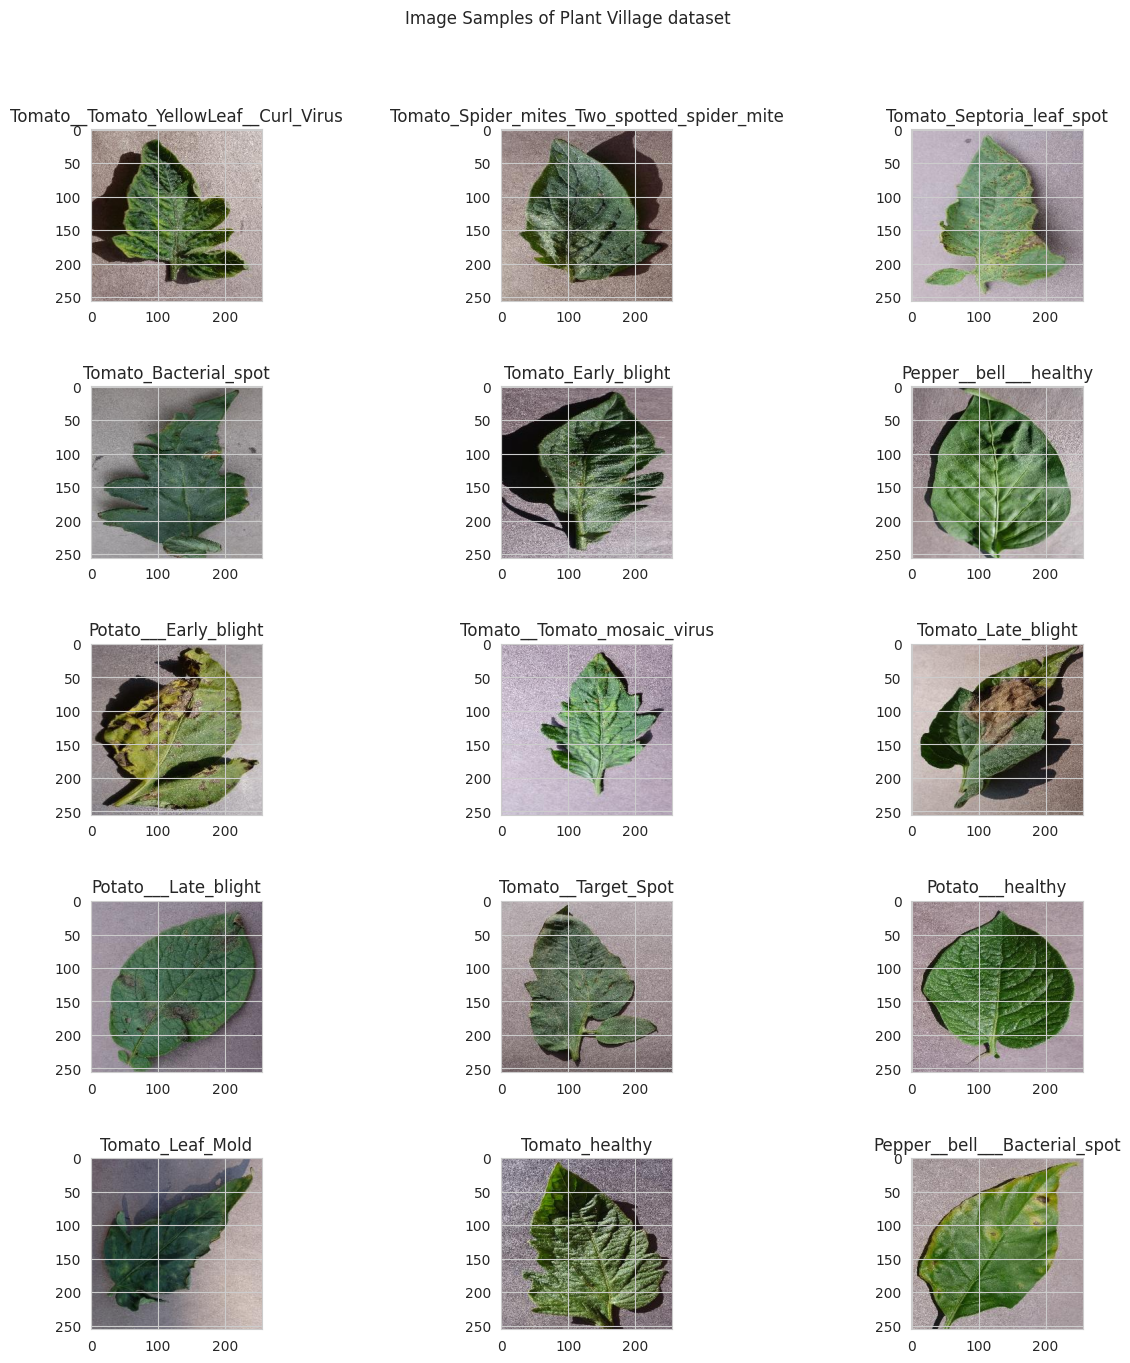

In [27]:
train.show_class_samples()

## Test Data Insights

In [28]:
test = Dataset("dataset/test/")

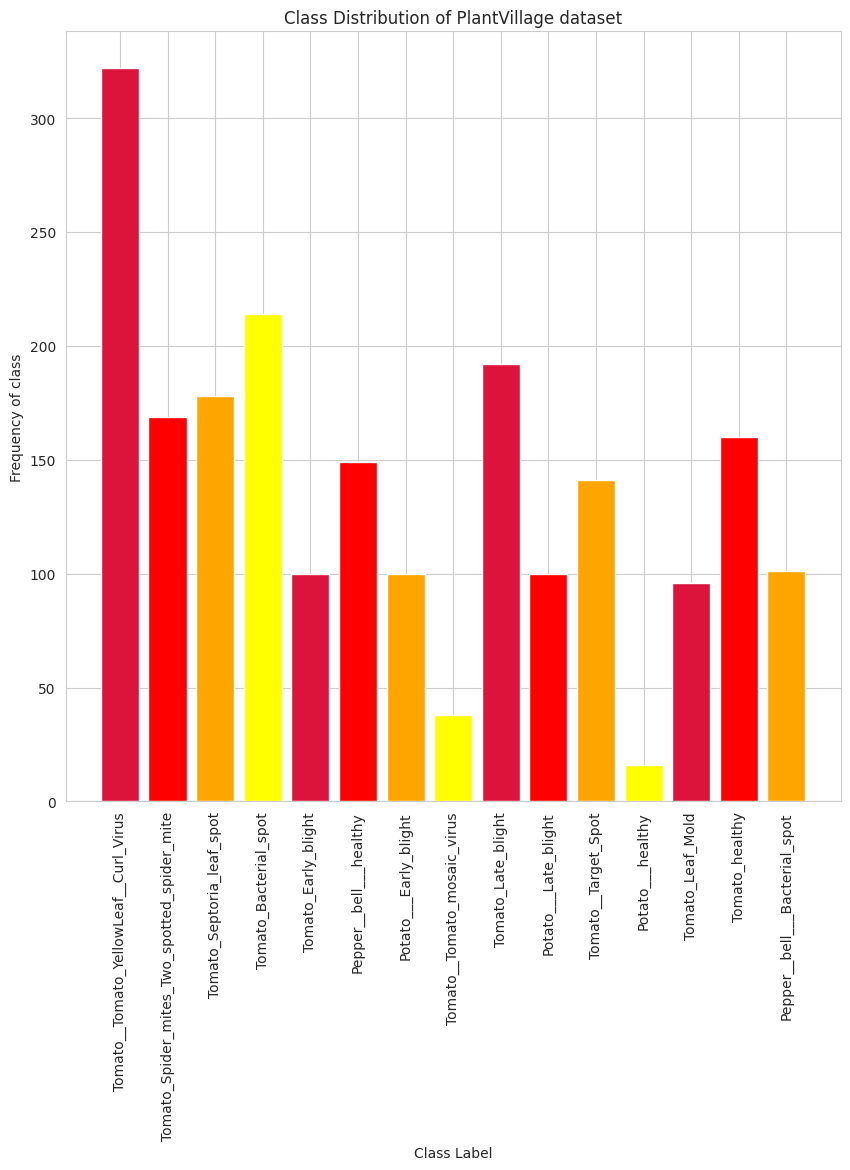

In [29]:
test.class_distributions()

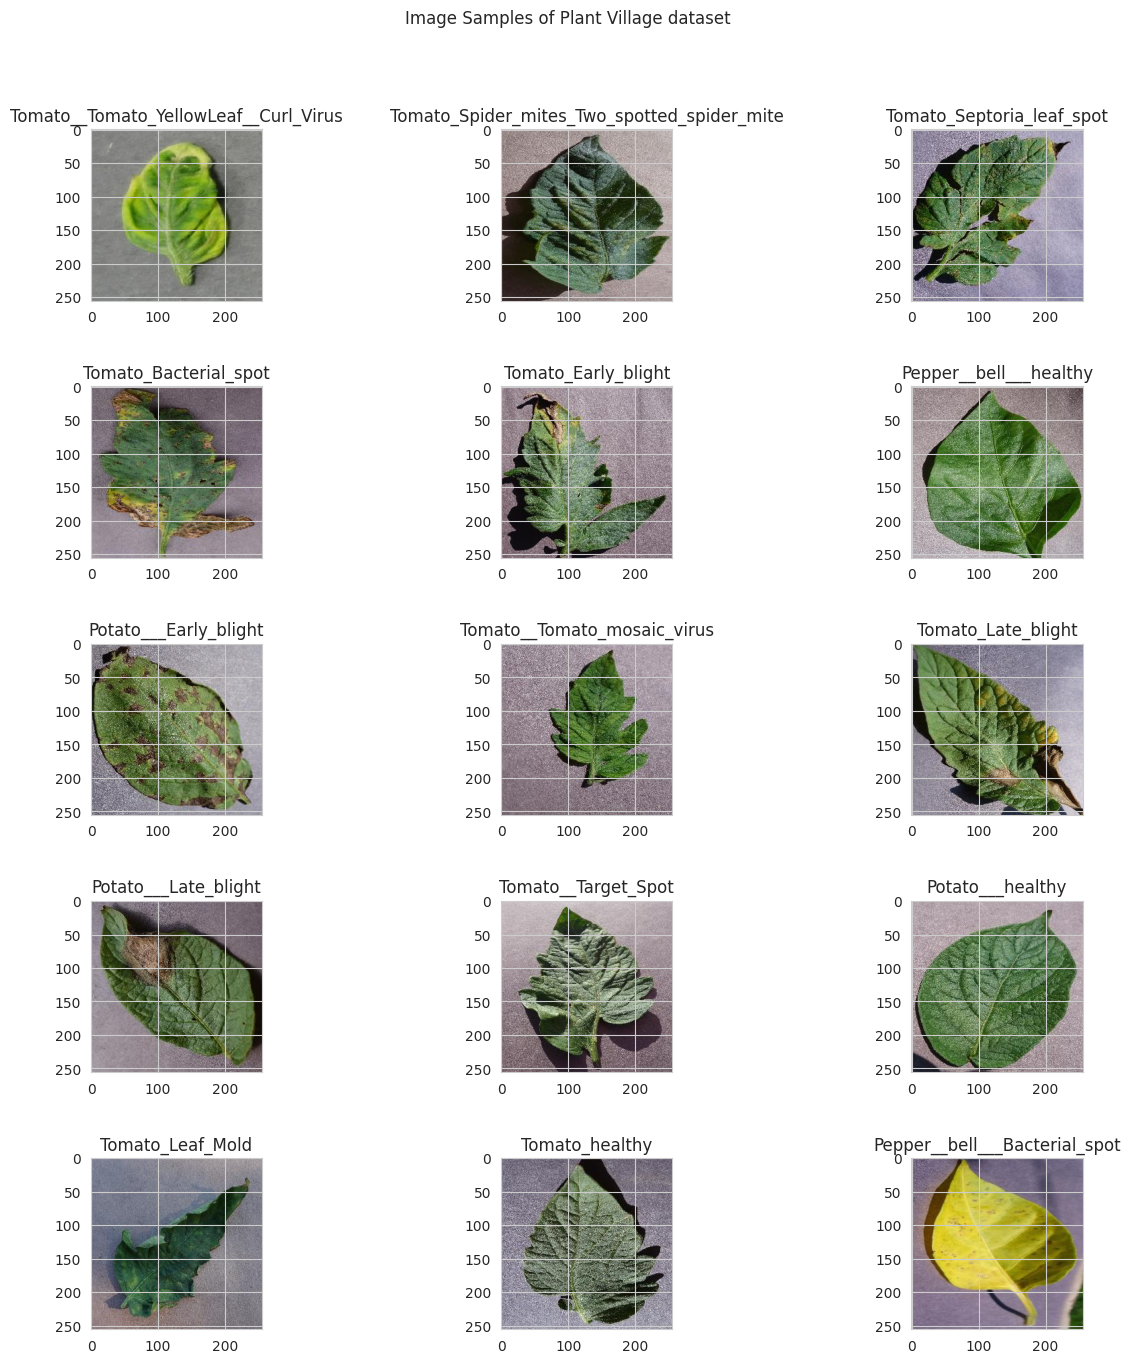

In [30]:
test.show_class_samples()

## Validation Data Insights

In [31]:
val = Dataset("dataset/val/")

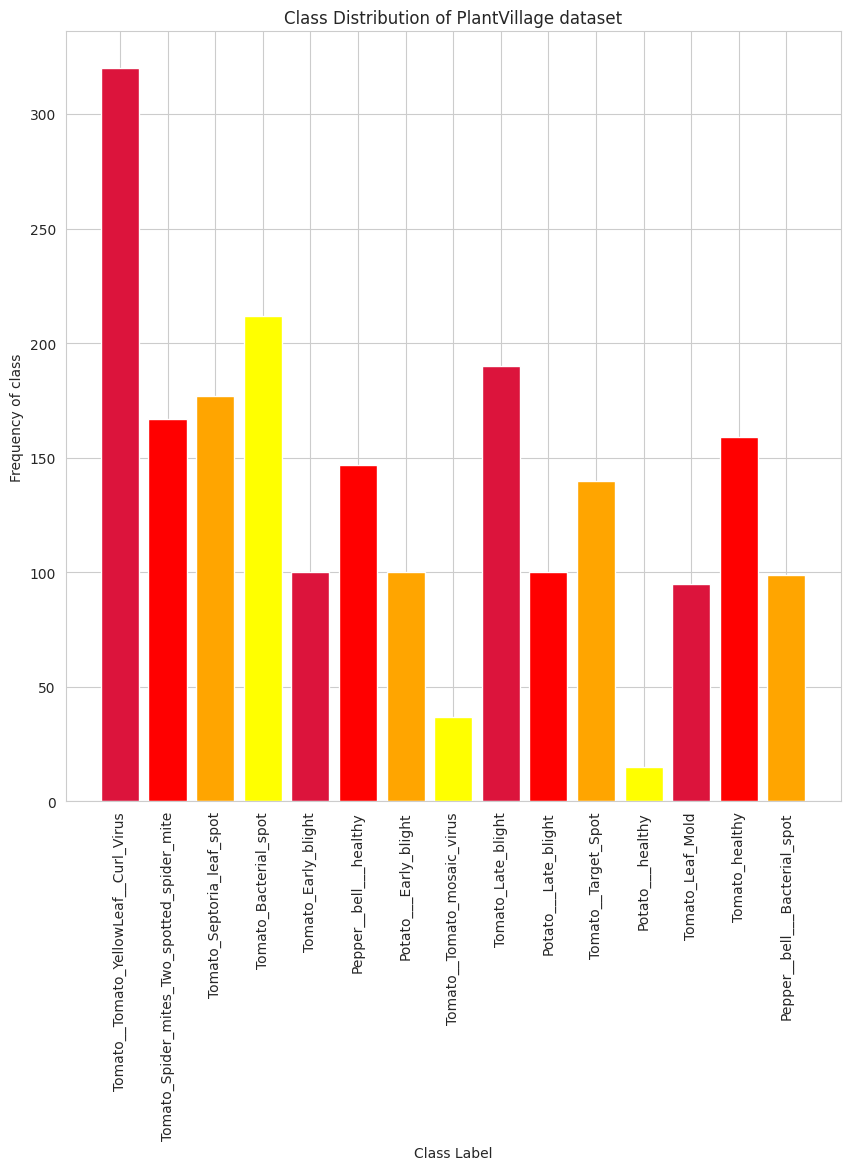

In [32]:
val.class_distributions()

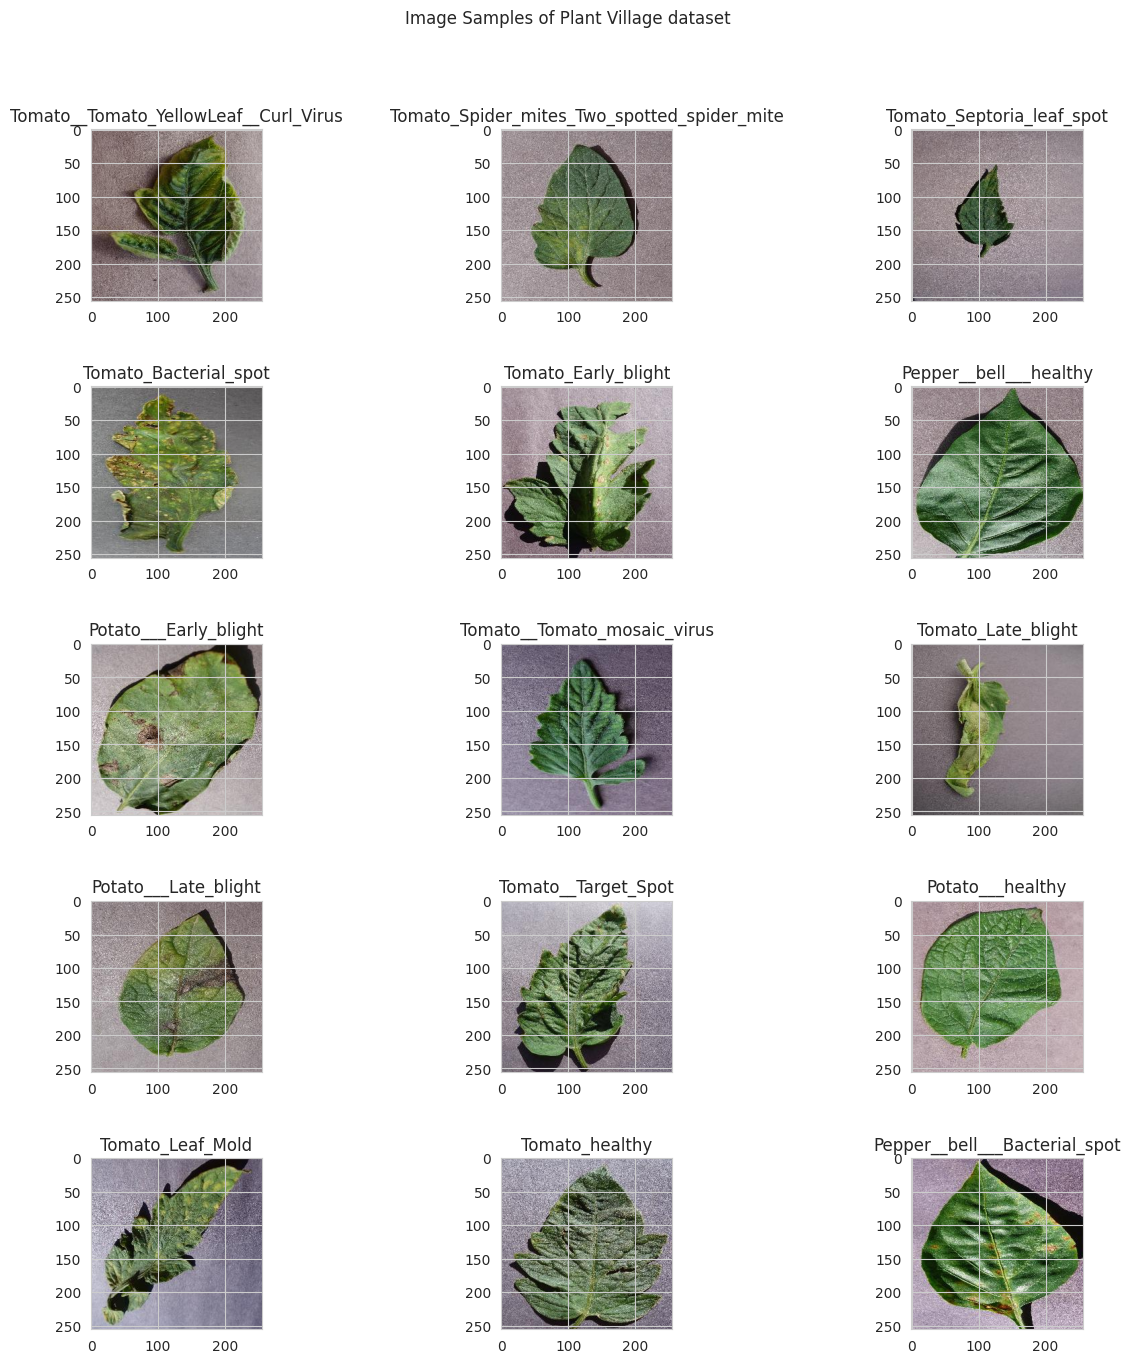

In [33]:
val.show_class_samples()

## Creating the data generators

In [34]:
ds.create_generators()

In [35]:
train, val, test = ds.get_images()

Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.


# Transfer Learning

In [36]:
class TransferLearning:

    def __init__(self, train, val) -> None:
        self.train = train
        self.val = val
        self.model = None
        self.history = None

    def load_model(self):
        self.model = ResNet50(weights = 'imagenet', 
                              include_top = False, 
                              input_shape = (75,75,3))
    
    def mark_layers_non_trainable(self):
        for layer in self.model.layers:
            layer.trainable = False
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(15, activation = 'softmax')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
    def train_model(self):
        self.history = self.model.fit(train,
                                      batch_size=32, 
                                      epochs=10, validation_data=val)
    
    def plot_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

## Transfer Learning using Resnet50

In [37]:
tl = TransferLearning(train=train, val=val)

## Loading the Resnet50 from Keras Application

In [38]:
tl.load_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Making all the layers of the model non-trainable

In [43]:
tl.mark_layers_non_trainable()

## Adding a final layer for classification of 15 classes

In [40]:
tl.add_final_layer()

## Compiling model

In [41]:
tl.compile_model()

## Training model

In [44]:
tl.train_model()

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 323s 626ms/step - accuracy: 0.9306 - loss: 0.2121 - val_accuracy: 0.8800 - val_loss: 0.4038
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 317s 614ms/step - accuracy: 0.9549 - loss: 0.1300 - val_accuracy: 0.9018 - val_loss: 0.3809
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 330s 630ms/step - accuracy: 0.9622 - loss: 0.1127 - val_accuracy: 0.9193 - val_loss: 0.3064
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 383s 632ms/step - accuracy: 0.9793 - loss: 0.0639 - val_accuracy: 0.8683 - val_loss: 0.6121
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 329s 637ms/step - accuracy: 0.9698 - loss: 0.0995 - val_accuracy: 0.9033 - val_loss: 0.4597
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 338s 654ms/step - accuracy: 0.9766 - loss: 0.0749 - val_accuracy: 0.9004 - val_loss: 0.5113
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 337s 653ms/step - accuracy: 0.9688 - loss: 0.1104 - val_accuracy: 0.9106 - val_loss: 0.4735
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 324s 627ms/step - accuracy: 0.9825 -

In [61]:
tl.model.save("models/first_model.h5")

In [46]:
CLASS_NAMES = list(train.class_indices.keys())
CLASS_NAMES

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [47]:
from sklearn.metrics import accuracy_score, classification_report

In [48]:
predictions = np.argmax(tl.model.predict(test), axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 413ms/step


Test Accuracy: 92.582%


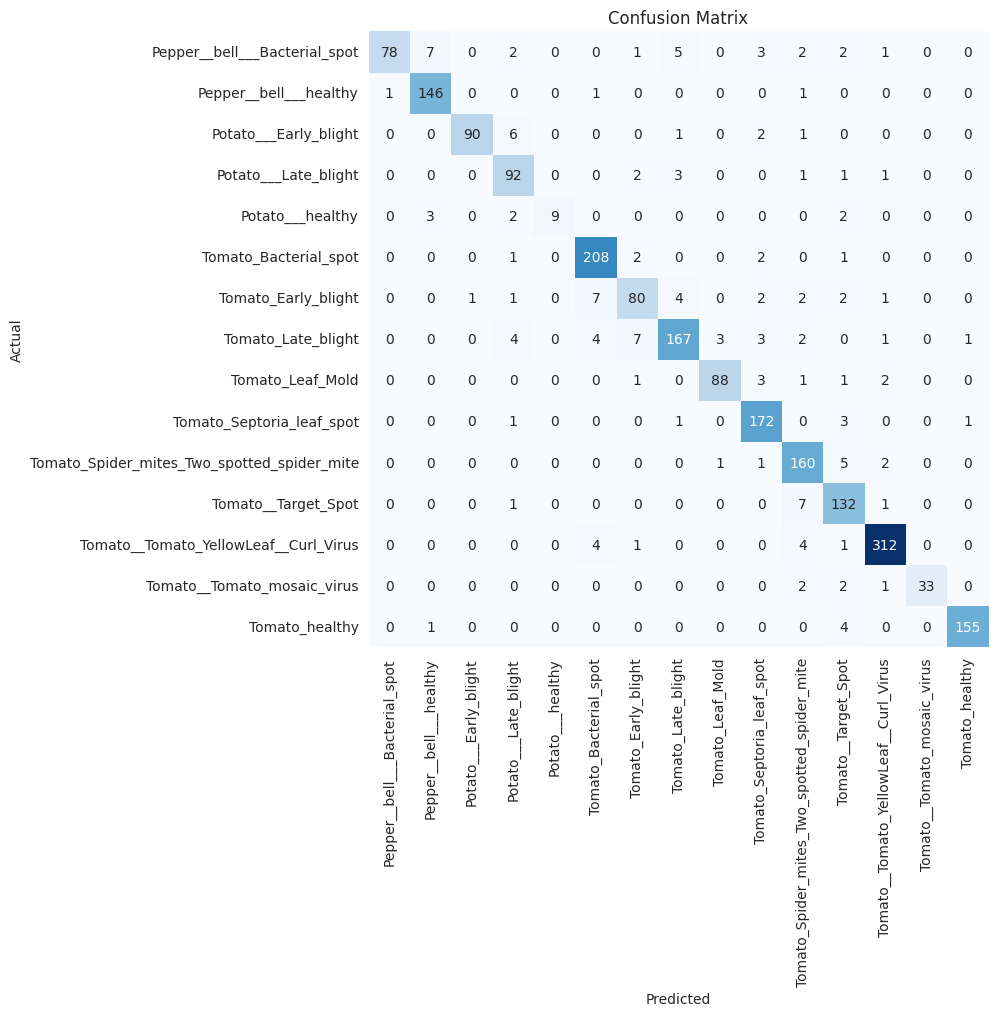

In [49]:
acc = accuracy_score(test.labels, predictions)
cm = tf.math.confusion_matrix(test.labels, predictions)
clr = classification_report(test.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=90)
plt.yticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [50]:
print(clr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.77      0.87       101
                     Pepper__bell___healthy       0.93      0.98      0.95       149
                      Potato___Early_blight       0.99      0.90      0.94       100
                       Potato___Late_blight       0.84      0.92      0.88       100
                           Potato___healthy       1.00      0.56      0.72        16
                      Tomato_Bacterial_spot       0.93      0.97      0.95       214
                        Tomato_Early_blight       0.85      0.80      0.82       100
                         Tomato_Late_blight       0.92      0.87      0.90       192
                           Tomato_Leaf_Mold       0.96      0.92      0.94        96
                  Tomato_Septoria_leaf_spot       0.91      0.97      0.94       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.87      0.95

## Plotting the Learning Curves

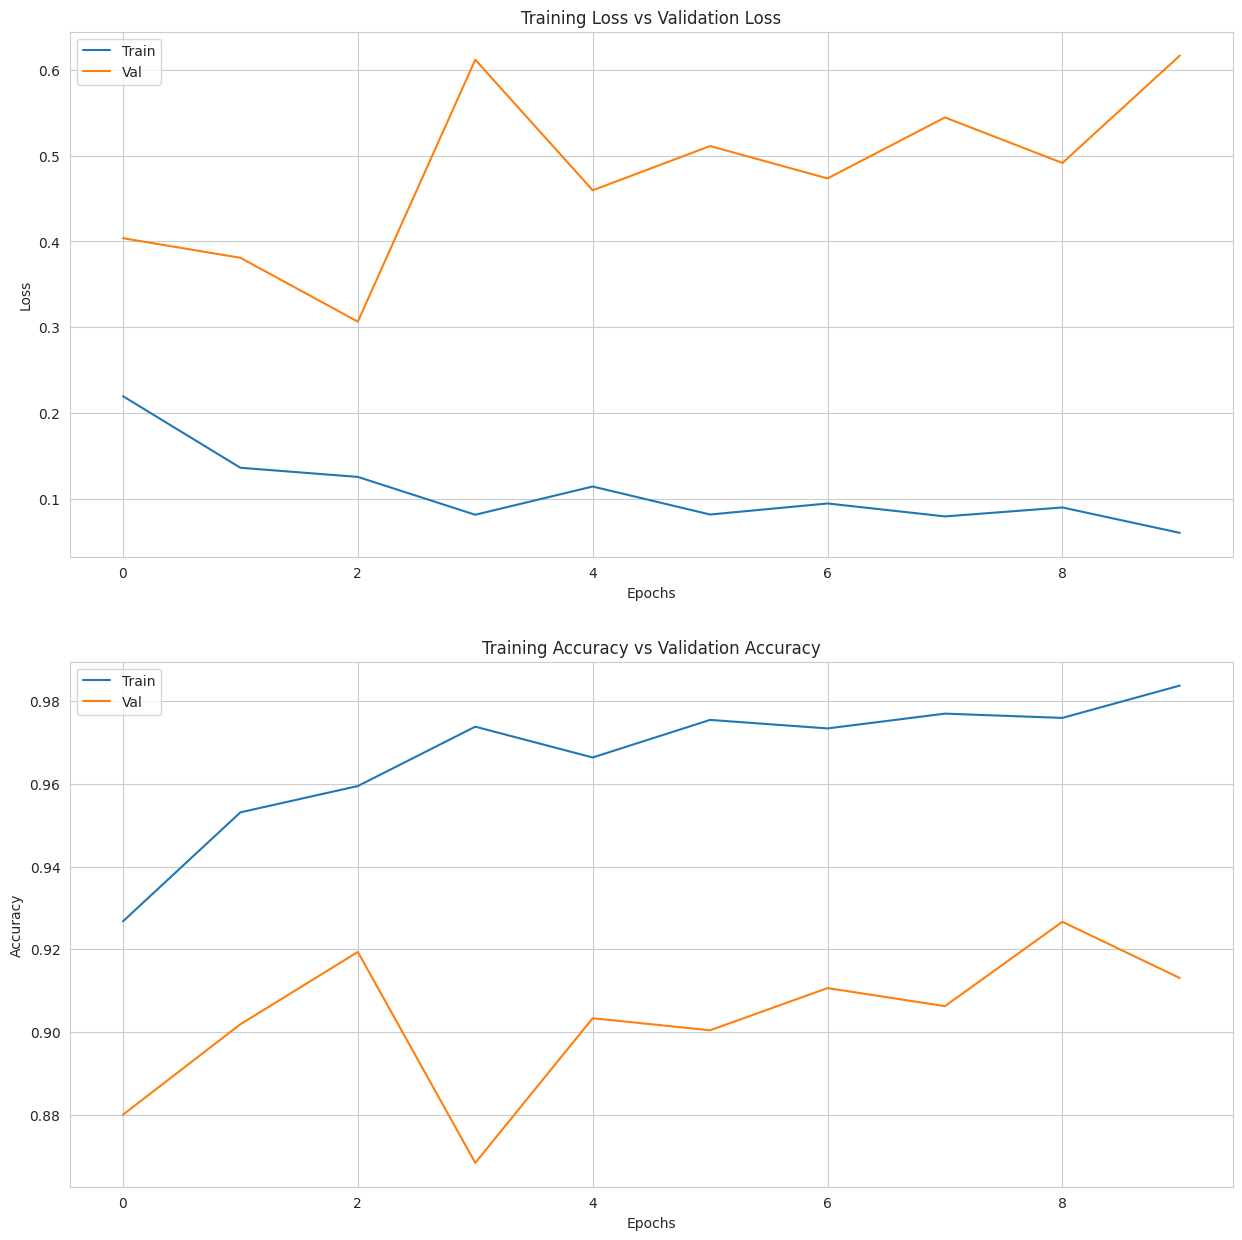

In [51]:
tl.plot_history()

- We can observe that model achieves an accuracy of 97.50% and 90.43% on training and validation sets respectively.
- Moreover, we can also gauge that the model is overfitting slightly which can be handled by fine tuning the model using regularization and re-training the layers

# Fine-tuning

Fine Tuning is the approach in which a pretrained model is used. However, few of the layers are made trainable to understand the patterns in the current dataset. Morevoer, regularization can also be added in the form of dropout layers.

In [52]:
class FineTuning:

    def __init__(self, train, val) -> None:
        self.train = train
        self.val = val
        self.model = None
        self.history = None
        self.fine_tune_from = 100

    def load_model(self):
        self.model = ResNet50(weights = 'imagenet', 
                              include_top = False, 
                              input_shape = (75,75,3))
    
    def fine_tune(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(15, activation = 'softmax')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
    def train_model(self):
        self.history = self.model.fit(train,
                                      batch_size=32, 
                                      epochs=5, 
                                      validation_data=val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True
                                        )
                                     ])
    
    def plot_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

## Fine Tuning the ResNet50 model

In [53]:
ft = FineTuning(train,val)

## Loading the ResNet50 model from keras applications

In [54]:
ft.load_model()

## Making last 75 layers of the ResNet50 model trainable

In [55]:
ft.fine_tune()

## Adding a final layer for classification of 15 classes

In [56]:
ft.add_final_layer()

## Compiling the model

In [57]:
ft.compile_model()

## Training the model for 5 epochs

In [58]:
ft.train_model()

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.7715 - loss: 1.3325 - val_accuracy: 0.9397 - val_loss: 0.1707
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 804s 2s/step - accuracy: 0.9495 - loss: 0.1735 - val_accuracy: 0.9485 - val_loss: 0.1661
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 862s 2s/step - accuracy: 0.9762 - loss: 0.1016 - val_accuracy: 0.9475 - val_loss: 0.1831
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 821s 2s/step - accuracy: 0.9823 - loss: 0.0631 - val_accuracy: 0.9534 - val_loss: 0.2221
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.9842 - loss: 0.0567 - val_accuracy: 0.9543 - val_loss: 0.1700


In [62]:
ft.model.save("models/second_model.h5")

In [60]:
predictions = np.argmax(ft.model.predict(test), axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step


Test Accuracy: 95.376%


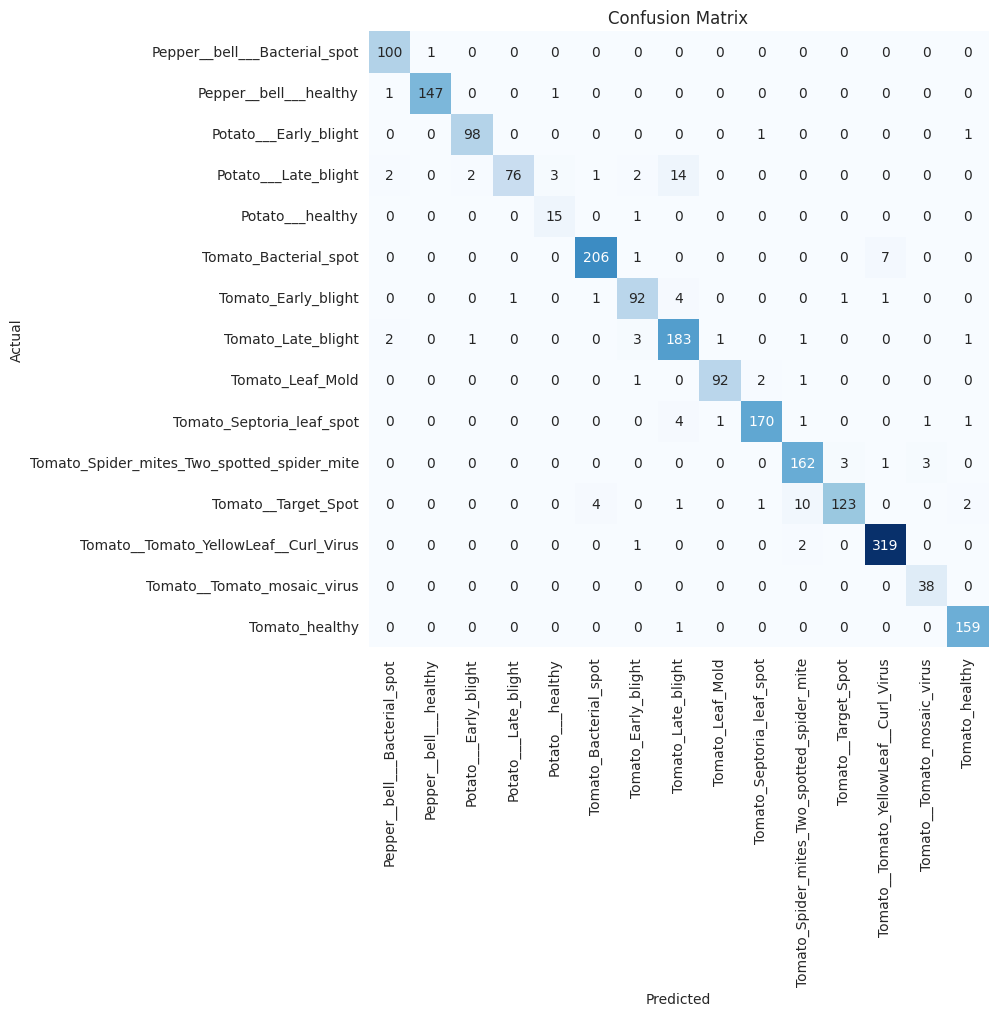

In [63]:
acc = accuracy_score(test.labels, predictions)
cm = tf.math.confusion_matrix(test.labels, predictions)
clr = classification_report(test.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=90)
plt.yticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:
print(clr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.99      0.97       101
                     Pepper__bell___healthy       0.99      0.99      0.99       149
                      Potato___Early_blight       0.97      0.98      0.98       100
                       Potato___Late_blight       0.99      0.76      0.86       100
                           Potato___healthy       0.79      0.94      0.86        16
                      Tomato_Bacterial_spot       0.97      0.96      0.97       214
                        Tomato_Early_blight       0.91      0.92      0.92       100
                         Tomato_Late_blight       0.88      0.95      0.92       192
                           Tomato_Leaf_Mold       0.98      0.96      0.97        96
                  Tomato_Septoria_leaf_spot       0.98      0.96      0.97       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.92      0.96

## Evaluation of the fine-tuned model

In [65]:
ft.model.evaluate(test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - accuracy: 0.9519 - loss: 0.1647


[0.1544826626777649, 0.9537572264671326]

## Plotting the learning curves of the fine-tuning process

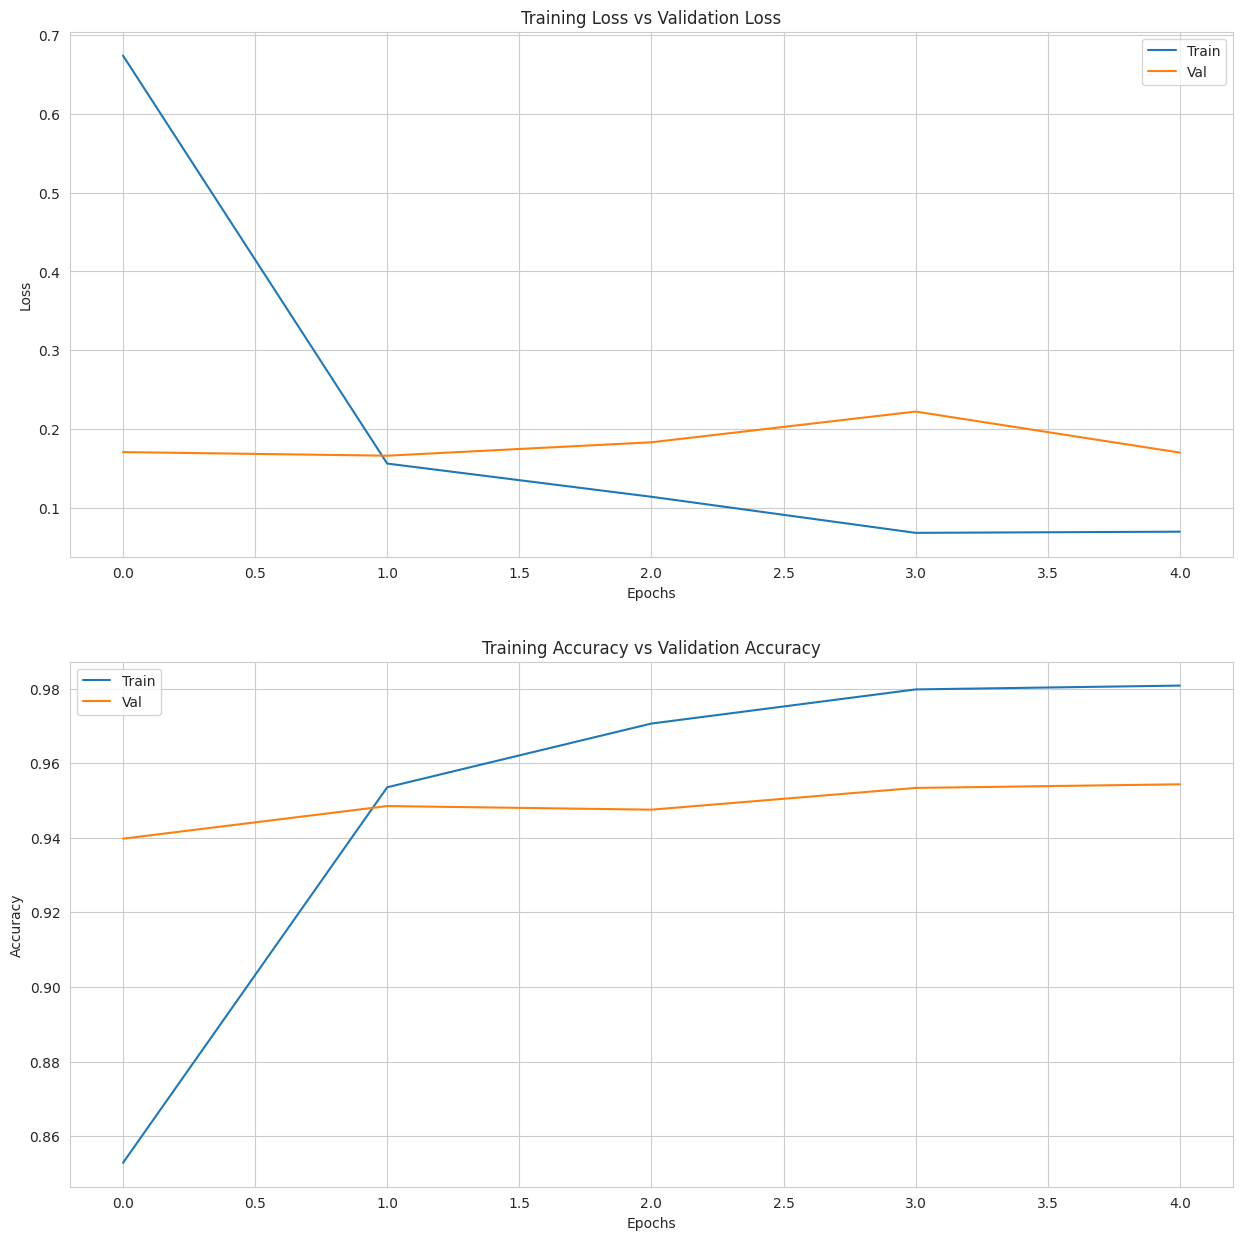

In [66]:
ft.plot_history()

# Conclusion

- Transfer Learning is approach of using a model pretrained(i.e. ResNet50) on a large dataset(here, imagenet) and using its knowledge for our case.
- As inferred earlier, transfer learning gives an accuracy of 97.50% and 90.43% on training and validation sets respectively which shows that the model is slightly overfitted resulting in the requirement of fine tuning of the model.
- The model is fine tuned by letting the last 75 layers learn the patterns in the dataset and overcome the overfitting and improve the accuracy.
- The fine tuned model gives an accuracy of 98.09%, 94.31%, and 95.23% on train, validation, and test splits.
- On a final note, in the deep learning there is required of the large overhead of time and hardware requirements for Fine Tuning of the model.